# Reinforcement Learning

# 6. Bandit Algorithms

This notebook presents **multi-armed bandit** algorithms.


In [1]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from lib.model import Environment
from lib.agent import Agent

## Multi-Armed Bandit

Multi-armed bandits are single-state models with random rewards.


In [4]:
class MAB(Environment):
    """Multi-Armed Bandit environnement.

    Parameters
    ----------
    distribution: string
        Reward distribution (Bernoulli, Uniform or Gaussian)
    params: list
        List of parameters (one per action)
        Example for Bernoulli (mean): [0.4, 0.5, 0.6]
        Example for Uniform (low, high): [(-1, 1), (0, 1), (-1, 2)]
        Example for Gaussian (mean, variance): [(0, 1), (1, 2), (-1, 1)]
    """

    def __init__(self, distribution="bernoulli", params=[0.4, 0.6]):
        if type(distribution) != str:
            raise ValueError(
                "The parameter 'distribution' must be a string: either 'bernoulli', 'uniform' or 'gaussian'."
            )
        self.distribution = distribution.lower()
        self.params = params

    @staticmethod
    def get_states():
        """Single state."""
        return [None]

    def get_actions(self):
        """One action per arm."""
        actions = [action for action, _ in enumerate(self.params)]
        return actions

    def get_reward(self, action):
        """Random reward. The parameter depends on the action."""
        if self.distribution == "bernoulli":
            return np.random.random() < self.params[action]
        if self.distribution == "uniform":
            low, high = self.params[action]
            return np.random.uniform(low, high)
        if self.distribution in ["gaussian", "normal"]:
            mean, std = self.params[action]
            return np.random.normal(mean, std)
        raise ValueError("Unknown distribution.")

    def get_model(self):
        raise ValueError("Not available.")

    def step(self, action):
        stop = False
        reward = self.get_reward(action)
        return reward, stop

In [5]:
class Bandit(Agent):
    """Bandit algorithm with random policy.

    Parameters
    ----------
    model : object of class MAB
        The model.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """

    def __init__(self, model, init_value=0, init_count=0):
        if not isinstance(model, MAB):
            raise ValueError("The model must be a multi-armed bandit.")
        self.model = model
        self.policy = self.random_policy
        actions = model.get_actions()
        self.values = len(actions) * [init_value]
        self.counts = len(actions) * [init_count]

    def get_actions(self, state=None):
        """Get all possible actions."""
        return self.model.get_actions()

    def get_episode(self, horizon=100):
        """Get the rewards for an episode and update the values."""
        state = None
        rewards = []
        for _ in range(horizon):
            action = self.get_action(state)
            reward, _ = self.model.step(action)
            rewards.append(reward)
            self.counts[action] += 1
            diff = reward - self.values[action]
            # update by temporal difference
            self.values[action] += diff / self.counts[action]
        return rewards

In [6]:
model = MAB()

In [7]:
model.distribution

'bernoulli'

In [8]:
model.params

[0.4, 0.6]

In [9]:
agent = Bandit(model)
agent.get_actions()

[0, 1]

In [10]:
rewards = agent.get_episode(horizon=100)
np.mean(rewards)

np.float64(0.47)

In [11]:
agent.values

[0.34545454545454546, 0.6222222222222222]

In [12]:
agent.counts

[55, 45]

## The $\varepsilon$-greedy policy


In [13]:
class Greedy(Bandit):
    """Bandit algorithm with epsilon-greedy policy.

    Parameters
    ----------
    model : object of class MAB
        The model.
    epsilon : float in [0, 1]
        Exploration rate.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """

    def __init__(self, model, epsilon=0.1, init_value=0, init_count=0):
        super(Greedy, self).__init__(model, init_value, init_count)
        self.epsilon = epsilon

    def get_action(self, state=None):
        """Get action with eps-greedy policy."""
        actions = self.get_actions()
        if np.random.random() > self.epsilon:
            # select the best action(s) with probability 1 - epsilon
            values = np.array(self.values)
            actions = np.flatnonzero(values == np.max(values))
        return np.random.choice(actions)

In [14]:
agent = Greedy(model)

In [15]:
rewards = agent.get_episode(horizon=100)

In [16]:
np.mean(rewards)

np.float64(0.58)

In [17]:
agent.values

[0.33333333333333337, 0.595744680851064]

In [18]:
agent.counts

[6, 94]

## To do


- Compute the expected **gain** for $\varepsilon = 0.2$ and check your result by simulation.<br>**Hint:** You might adapt the time horizon.
- Observe the phenomenon of **optimism in face of incertainty** when $\varepsilon = 0$.<br>**Hint:** You might adapt the parameters `init_value` and `init_count`.


We are working with a 2-armed bandit problem.
The expected gain can be computed as follows:

$$
\begin{aligned}
\mathbb{E}[G] & = (1 - \epsilon) \cdot \max(Q_a, Q_b) + \frac{\epsilon}{2} \cdot (Q_a + Q_b) \\
\end{aligned}
$$

We can see that we are taking the maximum of the two Q values with probability $1 - \epsilon$ and the average of the two Q values with probability $\epsilon$.

Setting $\epsilon = 0.2$, and recalling that $Q_a = 0.6$ and $Q_b = 0.4$, we can compute the corresponding expected gain as follows:

$$
\begin{aligned}
\mathbb{E}[G] & = 0.8 \cdot \max(Q_a, Q_b) + 0.1 \cdot (Q_a + Q_b) =\\
& = 0.8 \cdot 0.6 + 0.1 \cdot (0.4 + 0.6) =\\
& = 0.48 + 0.1 = 0.58
\end{aligned}
$$

We can calculate in the same way the expected gain for $\epsilon = 0.0$:

$$
\begin{aligned}
\mathbb{E}[G] & = 1 \cdot \max(Q_a, Q_b) + 0 \cdot (Q_a + Q_b) =\\
& = 1 \cdot 0.6 + 0 \cdot (0.4 + 0.6) =\\
& = 0.6
\end{aligned}
$$

Let's now check these results by simulation.


#### Using $\epsilon = 0.2$


In [19]:
agent = Greedy(model, epsilon=0.2)
rewards = agent.get_episode(horizon=100000)
qa, qb = agent.values
gain = np.mean(rewards)
print(f"Qa: {qa:.2f}, Qb: {qb:.2f}")
print(f"Expected gain with epsilon=0.2: {gain:.2f}")

Qa: 0.39, Qb: 0.60
Expected gain with epsilon=0.2: 0.58


#### Using $\epsilon = 0$


In [20]:
agent = Greedy(model, epsilon=0, init_value=1, init_count=1)
rewards = agent.get_episode(horizon=100000)
gain = np.mean(rewards)
print(f"Expected gain with epsilon=0: {gain:.2f}")

Expected gain with epsilon=0: 0.60


The simulation results are consistent with the theoretical calculations.


## The UCB policy

We now consider the UCB (Upper Confidence Bound) policy.


## To do

- Complete and test the agent `UCB` below.
- Plot the **regret** with respect to the time horizon, and compare with the $\varepsilon$-greedy policy for different values of $\varepsilon$.
- Repeat this experiment for the other models (uniform and Gaussian).<br> Interpret the results.
- Test the impact of the number of actions.


In [21]:
class UCB(Bandit):
    """Bandit algorithm with UCB policy.

    Parameters
    ----------
    model : object of class MAB
        The model.
    const : float in [0, 1]
        Multiplicative constant for the UCB bonus.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """

    def __init__(self, model, const=1, init_value=0, init_count=0):
        super(UCB, self).__init__(model, init_value, init_count)
        self.const = const

    def get_action(self, state=None):
        """Get action with UCB policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        actions = self.get_actions()
        # to be modified
        t = np.sum(counts)
        bonus = (
            np.sqrt(np.log(t) / (counts + 1e-6)) if t > 0 else np.zeros(len(actions))
        )
        ucb = values + self.const * bonus
        return actions[np.argmax(ucb)]

In [22]:
def calculate_regret(model, rewards):
    if model.distribution == "bernoulli":
        q_a = np.array(model.params)
    elif model.distribution == "uniform":
        q_a = np.array([np.mean(param) for param in model.params])
    elif model.distribution == "gaussian":
        q_a = np.array([mu for mu, _ in model.params])
    else:
        raise ValueError("Unknown distribution.")

    return np.cumsum(np.max(q_a) - rewards)

In [23]:
def regret_analysis(distribution, params, horizon, algorithm, eps_values=None, runs=50):
    model = MAB(distribution, params)

    if eps_values is None:
        agents = [algorithm(model)]
    else:
        agents = [
            (
                algorithm(model, eps)
                if eps > 0
                else algorithm(model, eps, init_value=1, init_count=1)
            )
            for eps in eps_values
        ]

    regrets_avg = []
    for agent in agents:
        regrets = []

        # number of runs in order to average the results and reduce the variance
        for _ in range(runs):
            rewards = agent.get_episode(horizon)
            regrets.append(calculate_regret(model, rewards))
        regrets_avg.append(np.mean(regrets, axis=0))

    return regrets_avg if len(agents) > 1 else regrets_avg[0]

In [24]:
def plot_regret(regrets, title, labels):
    plt.title(title)
    for regret, label in zip(regrets, labels):
        plt.plot(regret, label=label)
    plt.xlabel("Time step")
    plt.ylabel("Cumulative regret")
    plt.legend()
    plt.show()

#### Regret analysis for a 2-armed bandit problem, using epsilon-greedy and UCB for all the distributions


In [25]:
distributions = {
    "bernoulli": [0.4, 0.6],
    "uniform": [(-1, 1), (0, 1)],
    "gaussian": [(0, 1), (1, 2)],
}
eps_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
horizon = 2000

labels = [f"eps-greedy (eps = {eps})" for eps in eps_values] + ["UCB"]

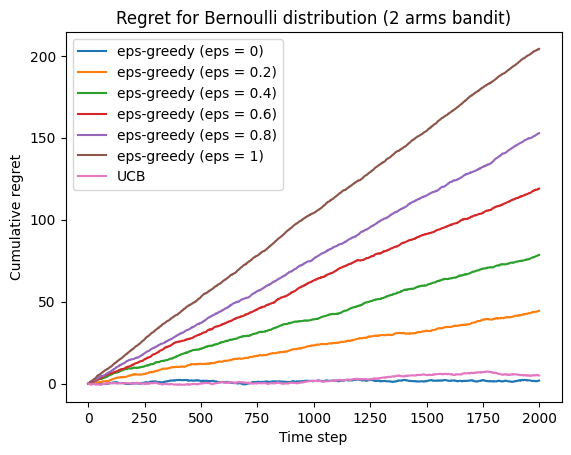

In [26]:
regrets_bernoulli = []
regrets_bernoulli.extend(
    regret_analysis(
        "bernoulli", distributions["bernoulli"], horizon, Greedy, eps_values
    )
)
regrets_bernoulli.append(
    regret_analysis("bernoulli", distributions["bernoulli"], horizon, UCB)
)

plot_regret(
    regrets_bernoulli,
    "Regret for Bernoulli distribution (2 arms bandit)",
    labels,
)

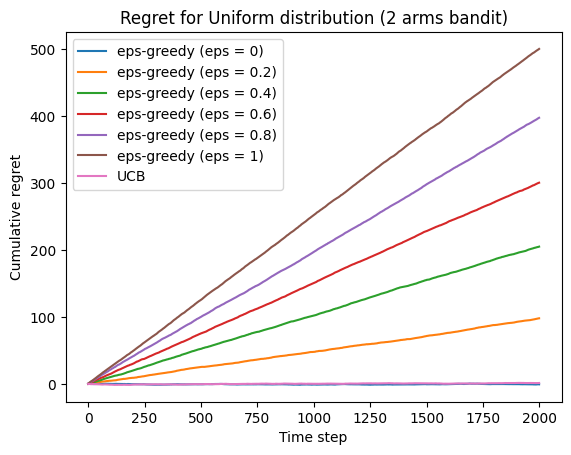

In [27]:
regrets_uniform = []
regrets_uniform.extend(
    regret_analysis("uniform", distributions["uniform"], horizon, Greedy, eps_values)
)
regrets_uniform.append(
    regret_analysis("uniform", distributions["uniform"], horizon, UCB)
)

plot_regret(
    regrets_uniform,
    "Regret for Uniform distribution (2 arms bandit)",
    labels,
)

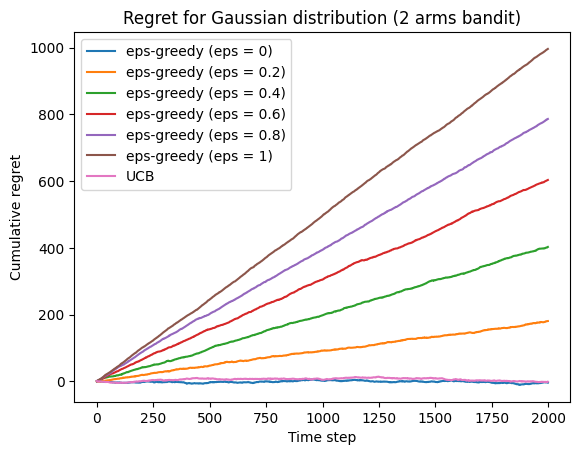

In [28]:
regrets_gaussian = []
regrets_gaussian.extend(
    regret_analysis("gaussian", distributions["gaussian"], horizon, Greedy, eps_values)
)
regrets_gaussian.append(
    regret_analysis("gaussian", distributions["gaussian"], horizon, UCB)
)

plot_regret(
    regrets_gaussian,
    "Regret for Gaussian distribution (2 arms bandit)",
    labels,
)

#### Regret analysis for a 3-armed bandit problem, using epsilon-greedy and UCB for all the distributions


In [29]:
distributions = {
    "bernoulli": [0.4, 0.5, 0.6],
    "uniform": [(-1, 1), (0, 1), (-1, 2)],
    "gaussian": [(0, 1), (1, 2), (-1, 1)],
}
eps_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
horizon = 2000

labels = [f"eps-greedy (eps = {eps})" for eps in eps_values] + ["UCB"]

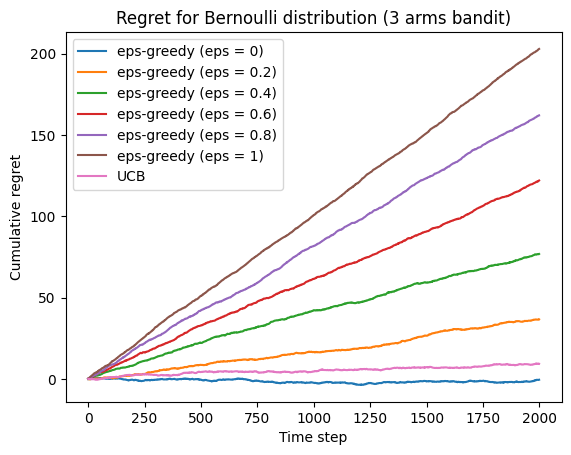

In [30]:
regrets_bernoulli = []
regrets_bernoulli.extend(
    regret_analysis(
        "bernoulli", distributions["bernoulli"], horizon, Greedy, eps_values
    )
)
regrets_bernoulli.append(
    regret_analysis("bernoulli", distributions["bernoulli"], horizon, UCB)
)

plot_regret(
    regrets_bernoulli,
    "Regret for Bernoulli distribution (3 arms bandit)",
    labels,
)

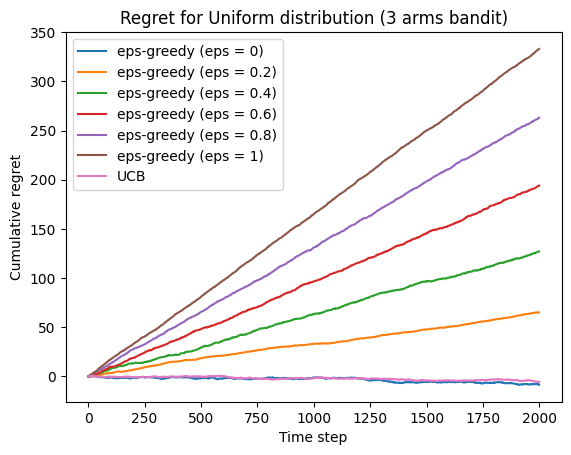

In [31]:
regrets_uniform = []
regrets_uniform.extend(
    regret_analysis("uniform", distributions["uniform"], horizon, Greedy, eps_values)
)
regrets_uniform.append(
    regret_analysis("uniform", distributions["uniform"], horizon, UCB)
)

plot_regret(
    regrets_uniform,
    "Regret for Uniform distribution (3 arms bandit)",
    labels,
)

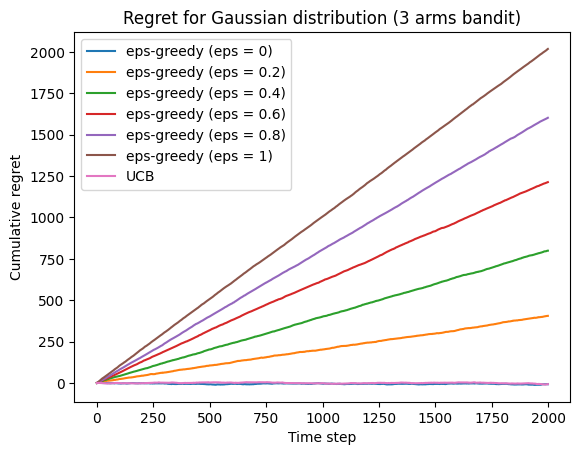

In [32]:
regrets_gaussian = []
regrets_gaussian.extend(
    regret_analysis("gaussian", distributions["gaussian"], horizon, Greedy, eps_values)
)
regrets_gaussian.append(
    regret_analysis("gaussian", distributions["gaussian"], horizon, UCB)
)

plot_regret(
    regrets_gaussian,
    "Regret for Gaussian distribution (3 arms bandit)",
    labels,
)

#### Regret analysis for a 5-armed bandit problem, using epsilon-greedy and UCB for all the distributions


In [33]:
distributions = {
    "bernoulli": [0.1, 0.2, 0.3, 0.4, 0.5],
    "uniform": [(-1, 1), (0, 1), (-1, 2), (0, 2), (-2, 2)],
    "gaussian": [(0, 1), (1, 2), (-1, 1), (0, 2), (-2, 2)],
}
eps_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
horizon = 2000

labels = [f"eps-greedy (eps = {eps})" for eps in eps_values] + ["UCB"]

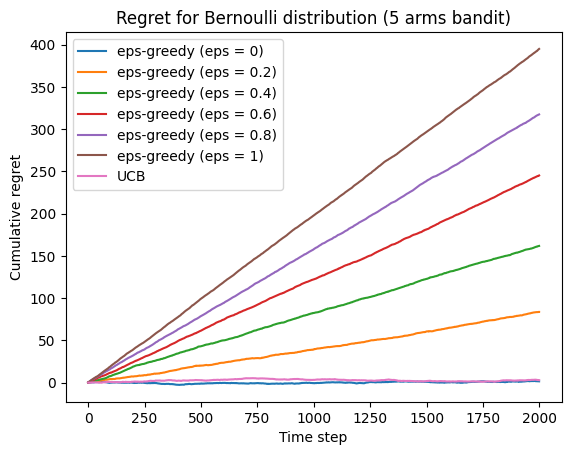

In [34]:
regrets_bernoulli = []
regrets_bernoulli.extend(
    regret_analysis(
        "bernoulli", distributions["bernoulli"], horizon, Greedy, eps_values
    )
)
regrets_bernoulli.append(
    regret_analysis("bernoulli", distributions["bernoulli"], horizon, UCB)
)

plot_regret(
    regrets_bernoulli,
    "Regret for Bernoulli distribution (5 arms bandit)",
    labels,
)

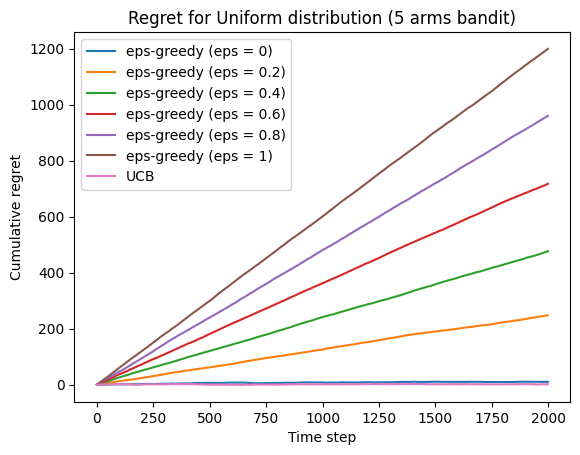

In [35]:
regrets_uniform = []
regrets_uniform.extend(
    regret_analysis("uniform", distributions["uniform"], horizon, Greedy, eps_values)
)
regrets_uniform.append(
    regret_analysis("uniform", distributions["uniform"], horizon, UCB)
)

plot_regret(
    regrets_uniform,
    "Regret for Uniform distribution (5 arms bandit)",
    labels,
)

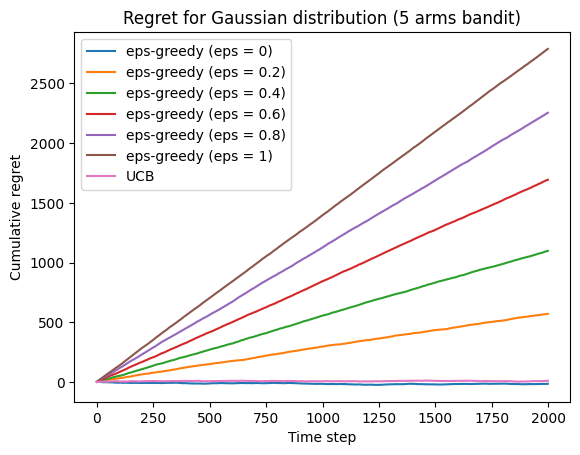

In [36]:
regrets_gaussian = []
regrets_gaussian.extend(
    regret_analysis("gaussian", distributions["gaussian"], horizon, Greedy, eps_values)
)
regrets_gaussian.append(
    regret_analysis("gaussian", distributions["gaussian"], horizon, UCB)
)

plot_regret(
    regrets_gaussian,
    "Regret for Gaussian distribution (5 arms bandit)",
    labels,
)

Increasing the number of actions increases the regret for all the distributions. This is because the agent has to explore more actions, and the probability of selecting the optimal action decreases.

Moreover, depending on the distribution and its parameters, the regret can be higher or lower.
For example, the regret is higher for the Gaussian distribution than for the Bernoulli distribution. This could be due to the fact that the Bernoulli distribution has a smaller variance than the Gaussian distribution, which makes it easier to find the optimal action.


## Thompson sampling


Finally, we consider Thompson Sampling, where the mean rewards are considered as random and sampled according to the posterior distribution (Bayesian algorithm).


## To do

- Complete and test the agent `TS` below.
- Plot the **regret** with respect to the time horizon, and compare with the UCB policy for different models.
- Which algorithm is the more efficient?<br> Comment your results.


In [37]:
class TS(Bandit):
    """Bandit algorithm with Thompson sampling.

    Parameters
    ----------
    model : object of class MAB
        The model.
    """

    def __init__(self, model):
        super(TS, self).__init__(model)
        self.distribution = model.distribution

    def get_action(self, state=None):
        """Get action with TS policy."""
        # S = values * counts
        # N = counts
        if self.distribution == "bernoulli":
            alpha = np.array(self.values) * self.counts + 1  # S + 1
            beta = self.counts - (np.array(self.values) * self.counts) + 1  # N - S + 1
            samples = np.random.beta(alpha, beta)
        else:  # gaussian or uniform distribution
            mean = self.values  # S / N
            std = 1 / np.sqrt(np.array(self.counts) + 1)  # 1 / sqrt(N + 1)
            samples = np.random.normal(mean, std)

        return np.argmax(samples)

#### Regret analysis for a 3-armed bandit problem, using UCB and Thompson Sampling for all the distributions


In [38]:
distributions = {
    "bernoulli": [0.4, 0.5, 0.6],
    "uniform": [(-1, 1), (0, 1), (-1, 2)],
    "gaussian": [(0, 1), (1, 2), (-1, 1)],
}
horizon = 5000

labels = ["UCB", "TS"]

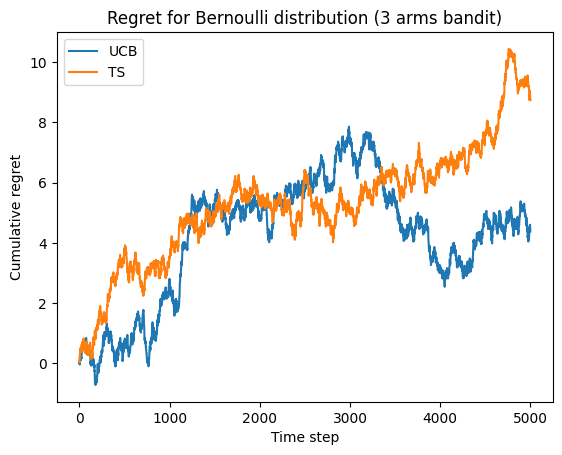

In [39]:
regrets_bernoulli = []
regrets_bernoulli.append(
    regret_analysis("bernoulli", distributions["bernoulli"], horizon, UCB)
)
regrets_bernoulli.append(
    regret_analysis("bernoulli", distributions["bernoulli"], horizon, TS)
)

plot_regret(
    regrets_bernoulli,
    "Regret for Bernoulli distribution (3 arms bandit)",
    labels,
)

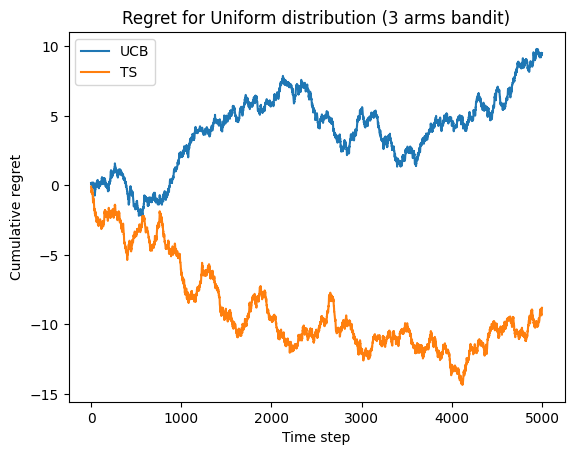

In [40]:
regrets_uniform = []
regrets_uniform.append(
    regret_analysis("uniform", distributions["uniform"], horizon, UCB)
)
regrets_uniform.append(
    regret_analysis("uniform", distributions["uniform"], horizon, TS)
)

plot_regret(
    regrets_uniform,
    "Regret for Uniform distribution (3 arms bandit)",
    labels,
)

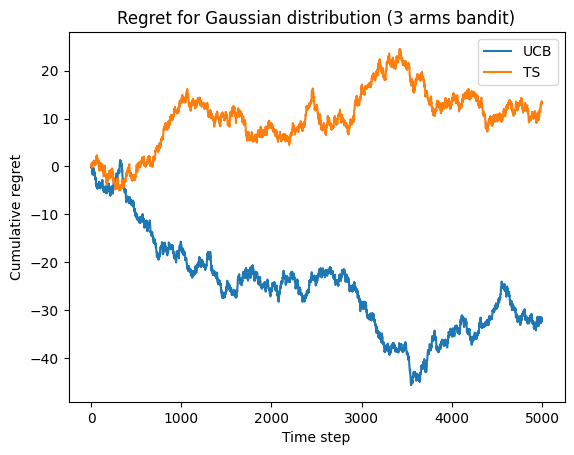

In [41]:
regrets_gaussian = []
regrets_gaussian.append(
    regret_analysis("gaussian", distributions["gaussian"], horizon, UCB)
)
regrets_gaussian.append(
    regret_analysis("gaussian", distributions["gaussian"], horizon, TS)
)

plot_regret(
    regrets_gaussian,
    "Regret for Gaussian distribution (3 arms bandit)",
    labels,
)

We can see that depending on the distribution, the UCB or Thompson Sampling algorithm can be more or less efficient than the other.
